# 2019-nCov Analysis, $R_0$ estimation
### Affan Shoukat

### Model Fitting and  stochastic simulations of 41 cases for which we know symptom on-set. 

The script is standalone but requires reading data from "ncovdata_initial41.csv", located in the `data` folder. This script fits an exponential model to the incidence/prevalence **of the 41 cases** for which we know symptom on-set. The script saves the fitted data in a file which is used by the R script `epi-estim-analysis.R` to compute temporal R0. This script also generates `n` epidemic curves using negative binomial distributions.

The data for symptom-onset of 41 cases were collected from Huang et al, in the Lancet. 

In [1]:
# load packages
using Distributions, DataFrames, CSV, Query, VegaLite, LsqFit, Plots, PrettyTables, StatsPlots, Interpolations
using Base.Iterators, Random
pyplot()
#PyPlot.svg(true)
pwd()

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling CSV [336ed68f-0bac-5ca0-87d4-7b16caf5d00b]
└ @ Base loading.jl:1273
┌ Info: Precompiling Query [1a8c2f83-1ff3-5112-b086-8aa67b057ba1]
└ @ Base loading.jl:1273
┌ Info: Precompiling VegaLite [112f6efa-9a02-5b7d-90c0-432ed331239a]
└ @ Base loading.jl:1273
┌ Info: Precompiling LsqFit [2fda8390-95c7-5789-9bda-21331edee243]
└ @ Base loading.jl:1273
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273


"C:\\Users\\affan\\OneDrive\\Documents\\postdoc projects\\2019-ncov"

In [91]:
## read the data and calculate incidence.

#df = CSV.read("../data/ncovdata.csv", datarow=2, header=["tdx", "date", "cumcases", "cumcases_intl"], types=[Int64, Int64, Union{Int64, Missing}, Int64])
df = CSV.read("./data/ncovdata_initial41.csv", datarow=2)

# are we underreporting if 20% underreporting, use factor 1.25 (1/(1-0.20)). 
# if 50% underreporting, use factor 2
# if 80% underreporting, use factor 5
# if 90% underreporting, use factor 10
ur_factor = 1
scenstr = "baseline"
#datefilter = 26
#df[!, :cumcases] .= Int.(round.(df.cumcases .* ur_factor))

#pretty_table(df)

# we are going to redistributed the cumulative number of cases on december 16 (which is confirmed) to january 1st to 16th
#df[1:5, :cumcases] .= 0 


## calculate incidence
#_tmp = circshift(df.cumcases, 1)
#_tmp[1] = 0
#df[!, :inc] = df.cumcases - _tmp

#df = df |> @filter(_.date <= datefilter) |> DataFrame
rename!(df, :allcases_cum => :cumcases)
pretty_table(df, crop=:none)

┌───────┬───────────┬───────────────────────┬───────────────────────┬───────────┬─────────┬──────────┐
│   tdx │      date │             inc_nomkt │               inc_mkt │ cum_nomkt │ cum_mkt │ cumcases │
│ Int64 │    String │ Union{Missing, Int64} │ Union{Missing, Int64} │     Int64 │   Int64 │    Int64 │
├───────┼───────────┼───────────────────────┼───────────────────────┼───────────┼─────────┼──────────┤
│     1 │ 01-Dec-19 │                     1 │               missing │         1 │       0 │        1 │
│     2 │ 02-Dec-19 │               missing │               missing │         1 │       0 │        1 │
│     3 │ 03-Dec-19 │               missing │               missing │         1 │       0 │        1 │
│     4 │ 04-Dec-19 │               missing │               missing │         1 │       0 │        1 │
│     5 │ 05-Dec-19 │               missing │               missing │         1 │       0 │        1 │
│     6 │ 06-Dec-19 │               missing │               missing │    

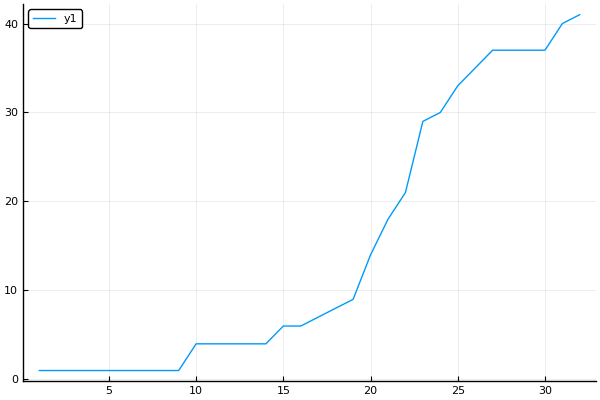

In [92]:
plot(df.tdx, df.cumcases)

In [28]:
# let's fit Richard's Model on our data 
# define the function first
@. richards_model(x, p) = 41 / (1+exp(-p[3]*p[1]*(x-p[2])))^(1/p[1])


richards_model (generic function with 1 method)

In [93]:
p0 = [2, 20, 0.5]
xdata = Vector(df.tdx)
ydata = Vector(df.cumcases)

fit = curve_fit(richards_model, xdata, ydata, p0)
sigma = stderror(fit)
# to get margin of error and confidence interval of each parameter at 5% significance level:
margin_of_error = margin_error(fit, 0.05)
confidence_inter = confidence_interval(fit, 0.05)

println("sigma: $sigma")
println("m of e: $margin_of_error")
println("c of i: $confidence_inter")
println("parameters: $(fit.param)")

sigma: [0.5089658056400017, 0.7324866370037211, 0.025656257639420536]
m of e: [1.0409519525268838, 1.4981033824661079, 0.0524729386303365]
c of i: Tuple{Float64,Float64}[(1.0593355040136365, 3.141239409067404), (22.62903454368602, 25.62524130861824), (0.17821584124102335, 0.28316171850169636)]
parameters: [2.1002874565405203, 24.12713792615213, 0.23068877987135986]


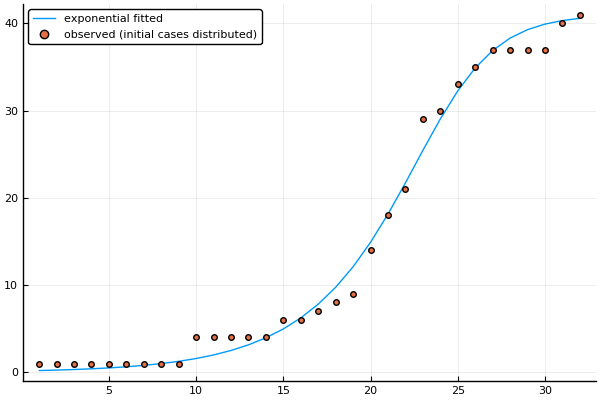

In [94]:
## run the fitted model to check the fit against the reported data. 
fittedvalues = richards_model(df.tdx, fit.param)
plot(df.tdx, fittedvalues, label="exponential fitted")
scatter!(df.tdx, df.cumcases, label="observed (initial cases distributed)")

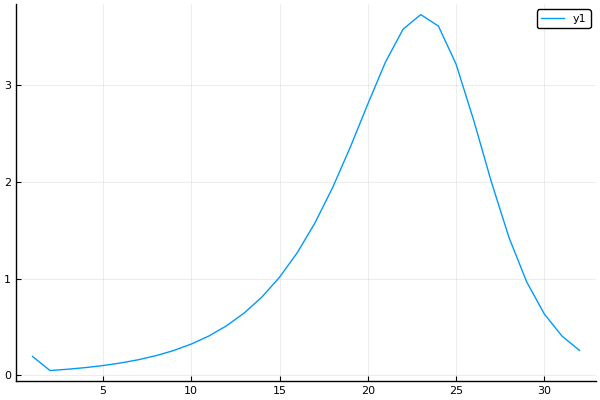

In [95]:
## calculate incidence
_tmp = circshift(fittedvalues, 1)
_tmp[1] = 0
#df[!, :inc] = fittedvalues - _tmp
myinc = fittedvalues - _tmp
plot(myinc)
#fvr = Int.(round.(myinc))  ## round the data
#plot(fvr)

In [45]:
# define a function calculate the coefficient of variation of cases in window w
function cv_window(y, w)
    ny = length(y)
    w2 = Int(floor(w/2))
    
    ran = (w2+1):(ny-w)
    println("offset datarange:$ran")
    s = zeros(Float64, ny)
    m = zeros(Float64, ny)
        
    for i in ran        
        s[i] = std(y[(i - w2):(i + w2)])
        m[i] = mean(y[(i - w2):(i + w2)])
    end
    cv = s./m
    return (s, m)
end

cv_window (generic function with 1 method)

In [96]:
# calculate the coefficient of variance
win = 8
sr, mr = cv_window(myinc, win)
cvr = sr./mr
cvr[(length(df.tdx) - win + 1):end] .= cvr[(length(df.tdx) - win)]

## calculate coefficient of variation for both rounded and non rounded cases. 
cv_dd = DataFrame(ht=df.tdx, sr=sr, mr=mr, cvr=cvr)
pretty_table(cv_dd, crop=:none)

offset datarange:5:24
┌───────┬─────────────────────┬─────────────────────┬─────────────────────┐
│    ht │                  sr │                  mr │                 cvr │
│ Int64 │             Float64 │             Float64 │             Float64 │
├───────┼─────────────────────┼─────────────────────┼─────────────────────┤
│   1.0 │                 0.0 │                 0.0 │                 NaN │
│   2.0 │                 0.0 │                 0.0 │                 NaN │
│   3.0 │                 0.0 │                 0.0 │                 NaN │
│   4.0 │                 0.0 │                 0.0 │                 NaN │
│   5.0 │ 0.07099669942415926 │ 0.13895213525496633 │   0.510943565522659 │
│   6.0 │ 0.09314896114498696 │ 0.15301814685668672 │  0.6087445382032246 │
│   7.0 │ 0.11721898334789424 │ 0.19265189806975322 │  0.6084496676251429 │
│   8.0 │ 0.14743124356818346 │ 0.24249695345020758 │  0.6079715290050266 │
│   9.0 │  0.1852725245667131 │ 0.30512765120759033 │  0.607196771

In [100]:
## create a data frame to save the results 
#DataFrame(datetime, fvr=fvr)
df[!, :cases] = myinc
df[!, :cv] = cv_dd.cvr
pretty_table(df, crop=:none)
CSV.write("./data/estimated_incidence_$(scenstr).dat", df)

┌───────┬───────────┬───────────────────────┬───────────────────────┬───────────┬─────────┬──────────┬─────────────────────┬─────────────────────┐
│   tdx │      date │             inc_nomkt │               inc_mkt │ cum_nomkt │ cum_mkt │ cumcases │               cases │                  cv │
│ Int64 │    String │ Union{Missing, Int64} │ Union{Missing, Int64} │     Int64 │   Int64 │    Int64 │             Float64 │             Float64 │
├───────┼───────────┼───────────────────────┼───────────────────────┼───────────┼─────────┼──────────┼─────────────────────┼─────────────────────┤
│     1 │ 01-Dec-19 │                     1 │               missing │         1 │       0 │        1 │ 0.19758120018388065 │                 NaN │
│     2 │ 02-Dec-19 │               missing │               missing │         1 │       0 │        1 │ 0.05126483762431455 │                 NaN │
│     3 │ 03-Dec-19 │               missing │               missing │         1 │       0 │        1 │ 0.0645653325645

"./data/estimated_incidence_baseline.dat"

### Simulations via Negative Binomial 
We assume the mean incidence is the mean of an Negative-Binomial observation process. The mean of this process is fitted on the mean incidence imputed from the cumulative incidence fitted by the Richards model.
The variance of the Neg-Binomial observation process is fitted on the variance of the observed daily incidence.

In [82]:
## Simulating negative binomial, we remove all the NANs and start where we have a a positive cv
## compare with the negative binomial we get from the R code. (eventually removing that part)
dd = DataFrame(copy(df))
nanrows = findall(x -> isnan(x), dd.cvr)
println("nanrows: $nanrows")
deleterows!(dd, nanrows)

nanrows: [1, 2, 3, 4]


,tdx,date,inc_nomkt,inc_mkt,cum_nomkt,cum_mkt,allcases_cum,inc
,Int64,String,Int64⍰,Int64⍰,Int64,Int64,Int64,Float64
1,5,05-Dec-19,missing,missing,1,0,1,0.10241
2,6,06-Dec-19,missing,missing,1,0,1,0.128973
3,7,07-Dec-19,missing,missing,1,0,1,0.162419
4,8,08-Dec-19,missing,missing,1,0,1,0.204524
5,9,09-Dec-19,missing,missing,1,0,1,0.257515
6,10,10-Dec-19,2,1,3,1,4,0.324175
7,11,11-Dec-19,missing,missing,3,1,4,0.407969
8,12,12-Dec-19,missing,missing,3,1,4,0.513171
9,13,13-Dec-19,missing,missing,3,1,4,0.644992


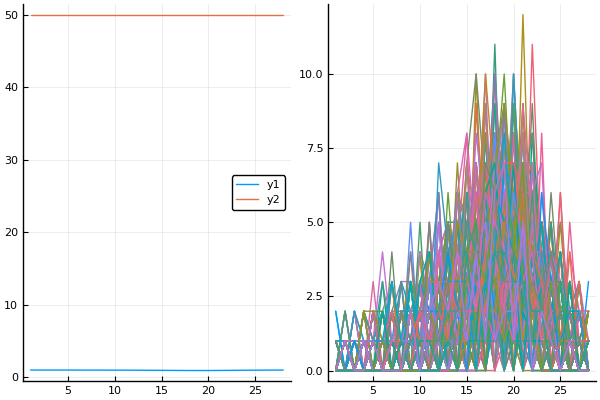

In [84]:
## do the negative binomial simulation
## mean/szv calculation from David's samoa measles code.
## convert the size/mean to probability

mean_inc = dd.inc
szv = @. 1/(dd.cvr^2 - 1/mean_inc)
#for numerical stability
szv[isinf.(szv)] .= 100
szv[szv .<= 0] .= 50

prob = @.  (szv./(szv.+mean_inc))
#prob[prob .== 0] .= 0.001

nb = NegativeBinomial.(szv, prob)  

sims = rand.(nb, 500)
sims = transpose(hcat(sims...) )

l = @layout [a  b]
p1 = plot(1:length(mean_inc), [prob, szv])
p2 = plot(1:length(mean_inc), sims, legend=false)

plot(p1, p2,  layout = l)
#@. dd.cv[24:27]^2 - 1/dd.cases[24:27]


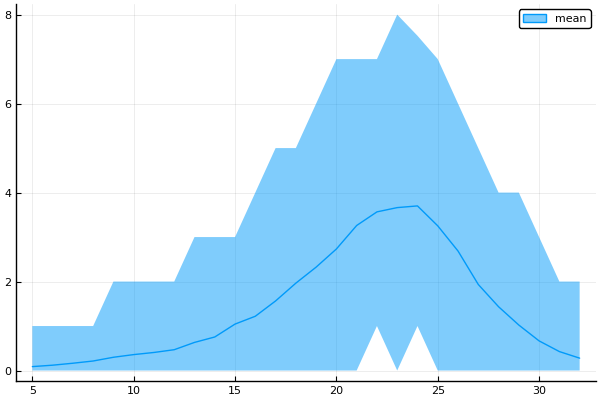

In [87]:
# summarize the data and average out the simulations. 
# need to put in a dataframe to be melted
simdf = DataFrame(sims)
insertcols!(simdf, 1, :time => dd.tdx)

# melt the data
simdf_melt = stack(simdf, [Symbol("x$i") for i = 1:500], [:time], variable_name=:mc, value_name=:value);

simdf_summary = simdf_melt |> @groupby(_.time) |>
    @map({time=key(_), m = mean(_.value), md = median(_.value), qlow = quantile(_.value, 0.025), qhi = quantile(_.value, 0.975)}) |> DataFrame


## the ribbon function here ADDS and SUBTRACTS the value from the main series data, so account for that.
@df simdf_summary plot(:time, [:m], label="mean", ribbon=(simdf_summary.m - simdf_summary.qlow, simdf_summary.qhi - simdf_summary.m))
